# CatBoost Tuning Phase 2 - Refined Values

In this notebook, we want to find the best hyperparameter values to use for our final model. We will use the narrowed hyperparameter search spaces found in Phase 1 of the tuning. In Phase 2, we will run 4-fold cross-validation on these narrowed parameter search spaces to get more refined results. This notebook will also take about 2 hours to run and the best hyperparameter results will be saved to a `.json` file.

In [ ]:
# pip3 install numpy pandas matplotlib scipy scikit-learn catboost optuna nbformat --upgrade
import time
import json

# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preparation
from sklearn.preprocessing import LabelEncoder

# Modelling
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

# Hyperparameter Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

# Custom Functions -> Function definitions can be found in utils.py file
from utils import MAP3, generate_model_rankings

In [ ]:
# Set seeds for reproducibility
sampler_seed = 346346
split_seed = 4326
model_seed = 36209436

In [3]:
# Read in the training data
train = pd.read_csv('Data/train.csv', index_col='id')
train = train.rename(columns={'Temparature':'Temperature'})
train.head()

,Temperature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


In [4]:
# Store the numeric and categorical columns
numeric_cols = ['Temperature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
categorical_cols = ['Soil Type', 'Crop Type']

# Extract feature columns and the target column
features = numeric_cols + categorical_cols
cat_cols_idxs = [int(inx) for inx in np.where(np.isin(features, categorical_cols))[0]]
target = 'Fertilizer Name'

In [5]:
# Fit LabelEncoder to the target
le = LabelEncoder()
le.fit(train[target])
class_mapping = list(le.classes_)
class_mapping

['10-26-26', '14-35-14', '17-17-17', '20-20', '28-28', 'DAP', 'Urea']

In [ ]:
# Tune on a subsample of the data to reduce computation time
tuning_data = train.sample(frac=0.05, random_state=sampler_seed)

In [ ]:
# Define the objective function for Optuna to optimize
fixed_params = {'boosting_type':'Ordered', 
                'loss_function':'MultiClass',
                'od_type':'IncToDec'}

def objective(trial: Trial, num_folds: int) -> float:
    """
    Objective function for Optuna hyperparameter tuning of a CatBoostClassifier using Stratified K-Fold cross-validation.

    This function defines the search space, samples hyperparameters for each trial,
    trains and evaluates the model using stratified cross-validation, uses early stopping in the training, 
    and returns the average MAP@3 score across all folds.

    Parameters
    ----------
    trial : Trial
        An Optuna Trial object used to suggest hyperparameters.
    num_folds : int
        The number of folds to use in Stratified K-Fold Cross-Validation.

    Returns
    -------
    float
        The average MAP@3 score across all cross-validation folds.
    """

    # Suggest remaining unconditional parameters
    hyperparameters = {
        'iterations':300, # Fix at 300 for tuning
        'learning_rate':trial.suggest_float('learning_rate', 0.02, 0.1, log=True), # log = True apparently biases Optuna toward better values
        'depth':trial.suggest_int('depth', 8, 12), # Allow for greater depths in phase 2 (max=12)
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.36, 0.7), # Allow for greater colsample by level since depth is greater
        'od_wait':trial.suggest_int('od_wait', 20, 49),
        'subsample':trial.suggest_float('subsample', 0.05, 0.38),
        'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 65, 90),
        'l2_leaf_reg':trial.suggest_float('l2_leaf_reg', 1.0, 3.0, log=True),
        'random_strength':trial.suggest_float('random_strength', 0.04, 0.2),
        'bootstrap_type':trial.suggest_categorical('bootstrap_type', ['Bernoulli', 'MVS']),
        'boosting_type':fixed_params['boosting_type'], # From early study results, it is clear that the boosting_type should be ordered. We don't need to explore this as thoroughly as the other variables
        'loss_function':fixed_params['loss_function'],
        'od_type':fixed_params['od_type'],
        'allow_writing_files': False, # Unless you want to analyze the report
        'random_seed': model_seed
    }

    # Training-Test Split with Stratified K-Fold Cross-Validation
    sk_folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=split_seed)

    # Get the features and the target
    X, y = tuning_data[features], tuning_data[target]

    # Initialize a list to keep track of the scores
    MAP3_folds_scores = []

    # Loop through the folds and get the MAP3 fold scores
    for train_indices, valid_indices in sk_folds.split(X, y):
        # Get the training features and target observations
        X_train_tune, y_train_tune = X.iloc[train_indices], y.iloc[train_indices]
        y_train_tune_encoded = le.transform(y_train_tune)

        # Get the test features and target observations
        X_valid_tune, y_valid_tune = X.iloc[valid_indices], y.iloc[valid_indices]
        y_valid_tune_encoded = le.transform(y_valid_tune)

        # Initialize the CatBoost model
        model = CatBoostClassifier(**hyperparameters, cat_features=cat_cols_idxs)

        # Fit the model on the training fold data
        model.fit(X_train_tune, 
                  y_train_tune_encoded,
                  eval_set=(X_valid_tune, y_valid_tune_encoded),
                  early_stopping_rounds=hyperparameters['od_wait'],
                  verbose=0)

        # Get the model rankings for the validation fold
        valid_fold_rankings = generate_model_rankings(model, X_valid_tune, class_mapping)

        # Compute the MAP3 score for this fold
        MAP3_fold_score = MAP3(labels=y_valid_tune, rankings=valid_fold_rankings)

        # Add the MAP3 score to the list of fold scores
        MAP3_folds_scores.append(MAP3_fold_score)

    # Return the average MAP3 score across all folds
    return np.mean(MAP3_folds_scores)

In [8]:
# Study parameters
trials = 50
start_up_trials = trials // 10 + 1
warmup_steps = 50
num_folds = 4 # Use 4 folds in phase 2
sampler = TPESampler(multivariate=True, seed=sampler_seed)
pruner = MedianPruner(n_startup_trials=start_up_trials, n_warmup_steps=warmup_steps)

# Study
study = optuna.create_study(
    direction='maximize', 
    pruner=pruner, 
    sampler=sampler,
    study_name='CatBoost_Tuning_Phase2'
)

# Run and time the study
start = time.time()
study.optimize(lambda trial: objective(trial, num_folds), n_trials=trials, timeout=7200) # Run 50 trials or stop after 2 hours
end = time.time()

# Print the total runtime
print('-----------------------------------------------------------')
print(f'Hyperparameter Tuning Runtime: {(end-start)/60:.2f} minutes.')

A new study created in memory with name: CatBoost_Tuning_Phase2
Trial 0 finished with value: 0.2888488888888889 and parameters: {'learning_rate': 0.04347527759761787, 'depth': 8, 'colsample_bylevel': 0.6962236782969772, 'od_wait': 33, 'subsample': 0.06437556419534844, 'min_data_in_leaf': 73, 'l2_leaf_reg': 1.5688504023169896, 'random_strength': 0.07369881313293966, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.2888488888888889.

Trial 1 finished with value: 0.28555111111111114 and parameters: {'learning_rate': 0.08285555909896472, 'depth': 10, 'colsample_bylevel': 0.4969815204555851, 'od_wait': 41, 'subsample': 0.06879677184092878, 'min_data_in_leaf': 73, 'l2_leaf_reg': 2.2377420984979075, 'random_strength': 0.13527521830158212, 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.2888488888888889.

Trial 2 finished with value: 0.2905466666666667 and parameters: {'learning_rate': 0.0391614767133417, 'depth': 10, 'colsample_bylevel': 0.5493498707044185, 'od_wait': 30,

-----------------------------------------------------------
Hyperparameter Tuning Runtime: 101.23 minutes.


In [9]:
# Save the best trial
best_trial = study.best_trial

# Save best parameters
best_params = best_trial.params
# Include the fixed parameters
for key, value in fixed_params.items():
    best_params[key] = value

# Save the study's best parameters to a file
with open('Study_Results/Phase2/best_params.json', 'w') as file:
    json.dump(best_params, file)

# Print the results
print(f'Best MAP@3: {study.best_value:.4f} achieved in Trial #{best_trial.number}')
print(f'Best hyperparameters: {best_params}')

# Save the od_wait parameter for later use
od_wait = best_params.pop('od_wait')

Best MAP@3: 0.2923 achieved in Trial #35
Best hyperparameters: {'learning_rate': 0.049745499889766426, 'depth': 10, 'colsample_bylevel': 0.46619923304859245, 'od_wait': 39, 'subsample': 0.06155900139866675, 'min_data_in_leaf': 90, 'l2_leaf_reg': 2.399719543149106, 'random_strength': 0.050324592372389315, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Ordered', 'loss_function': 'MultiClass', 'od_type': 'IncToDec'}


**Best Hyperparameter Selection - Phase 2**
- depth: 10
- learning_rate: 0.049745499889766426
- bootstrap_type: Bernoulli
- colsample_bylevel: 0.46619923304859245
- min_data_in_leaf: 90
- subsample: 0.06155900139866675
- random_strength: 0.050324592372389315
- l2_leaf_reg: 2.399719543149106
- boosting_type: Ordered
- loss_function: MultiClass
- od_type: IncToDec
- od_wait: 39

In [ ]:
# Examine the top 20 trials
top20_trials = sorted(study.trials, key=lambda trial: trial.value, reverse=True)[:20]
for i, trial in enumerate(top20_trials):
    print(f'MAP@3 = {trial.value:.4f} achieved on Trial #{trial.number} with parameters: {trial.params}')

MAP@3 = 0.2923 achieved on Trial #35 with parameters: {'learning_rate': 0.049745499889766426, 'depth': 10, 'colsample_bylevel': 0.46619923304859245, 'od_wait': 39, 'subsample': 0.06155900139866675, 'min_data_in_leaf': 90, 'l2_leaf_reg': 2.399719543149106, 'random_strength': 0.050324592372389315, 'bootstrap_type': 'Bernoulli'}

MAP@3 = 0.2905 achieved on Trial #2 with parameters: {'learning_rate': 0.0391614767133417, 'depth': 10, 'colsample_bylevel': 0.5493498707044185, 'od_wait': 30, 'subsample': 0.07238778196778539, 'min_data_in_leaf': 85, 'l2_leaf_reg': 2.4570272700906526, 'random_strength': 0.05575795473550638, 'bootstrap_type': 'Bernoulli'}

MAP@3 = 0.2903 achieved on Trial #26 with parameters: {'learning_rate': 0.042221897486034256, 'depth': 10, 'colsample_bylevel': 0.6467736531186911, 'od_wait': 22, 'subsample': 0.1759648947595891, 'min_data_in_leaf': 85, 'l2_leaf_reg': 1.877044367624782, 'random_strength': 0.0439242063615476, 'bootstrap_type': 'Bernoulli'}

MAP@3 = 0.2901 achiev

In [ ]:
# Put the top 20 trials into a dataframe
top20_df = pd.DataFrame([trial.params for trial in top20_trials])
top20_df['MAP@3'] = pd.Series([trial.value for trial in top20_trials])
top20_df

,learning_rate,depth,colsample_bylevel,od_wait,subsample,min_data_in_leaf,l2_leaf_reg,random_strength,bootstrap_type,MAP@3
0,0.049745,10,0.466199,39,0.061559,90,2.399720,0.050325,Bernoulli,0.292347
1,0.039161,10,0.549350,30,0.072388,85,2.457027,0.055758,Bernoulli,0.290547
2,0.042222,10,0.646774,22,0.175965,85,1.877044,0.043924,Bernoulli,0.290342
3,0.032647,10,0.619214,25,0.078507,88,2.077106,0.049761,Bernoulli,0.290053
4,0.072677,10,0.538590,28,0.056816,86,2.374293,0.072943,Bernoulli,0.289751
5,0.022360,10,0.605559,33,0.218880,79,1.579052,0.047024,MVS,0.289600
6,0.053643,8,0.495752,43,0.126470,87,1.689726,0.040427,MVS,0.289116
7,0.061059,11,0.549784,34,0.069805,85,1.918204,0.049990,MVS,0.289089
8,0.024737,12,0.684191,41,0.288725,86,2.117400,0.043846,Bernoulli,0.288964
9,0.039013,9,0.596458,24,0.199024,87,2.678892,0.080367,MVS,0.288876


In [ ]:
# Get a sense of the value ranges for the numeric parameters
top20_df.describe()

,learning_rate,depth,colsample_bylevel,od_wait,subsample,min_data_in_leaf,l2_leaf_reg,random_strength,MAP@3
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.043425,9.800000,0.571644,30.900000,0.123505,85.600000,2.044555,0.059546,0.289201
std,0.015981,1.056309,0.069154,6.616566,0.077214,4.031455,0.388735,0.014309,0.001008
min,0.022360,8.000000,0.466199,22.000000,0.053786,73.000000,1.287612,0.040427,0.288244
25%,0.031475,9.000000,0.513292,24.750000,0.068603,84.750000,1.809569,0.049500,0.288603
50%,0.040490,10.000000,0.579786,30.000000,0.085762,86.000000,2.054793,0.054179,0.288862
75%,0.054118,10.000000,0.620090,35.250000,0.181730,88.250000,2.380649,0.073132,0.289638
max,0.080224,12.000000,0.696224,43.000000,0.288725,90.000000,2.678892,0.083923,0.292347


In [ ]:
# Get the frequency counts of the categorical data
print(top20_df['bootstrap_type'].value_counts())

bootstrap_type
Bernoulli    13
MVS           7
Name: count, dtype: int64


In [15]:
# Save study trial results
study_dataframe = study.trials_dataframe()
study_dataframe.to_csv('Study_Results/Phase2/trials.csv')

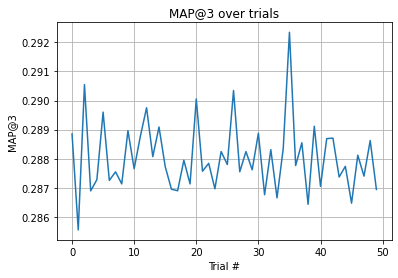

In [16]:
# Examine top trial results and performance trend
study_dataframe['value'].plot(title='MAP@3 over trials', xlabel='Trial #', ylabel='MAP@3')
plt.grid(True)
plt.show()

We narrowed the search space quite a bit in Phase 1, so the MAP@3 scores in this phase are quite similar for most of the trials. Every little bit of improvement helps for competition purposes, though.

In [17]:
# An interactive version of the plot above
plot_optimization_history(study).show()

In [18]:
# Plot Paramerter Importances
plot_param_importances(study).show()

Interestingly, the random_strength had the most importance in this phase of the tuning, not the learning rate.

In [19]:
# Plot Multivariate Visualization
plot_parallel_coordinate(study).show()

## Notes:
# - Each line is a trial
# - X-axis has the hyperparameters
# - Y-axis is the hyperparameter value
# - Color is the Objective Value
# - See which parameter ranges tend to result in better scores

## Conclusion
We have saved the best hyperparameter values from our tuning into a `.json` file which will be used in the next step - model validation.